In [64]:
import numpy as np 
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms, datasets  
from torchvision.transforms import ToTensor, Pad, Compose,CenterCrop, ToPILImage, Normalize, ConvertImageDtype, Resize
from PIL import Image
import torch.nn as nn
from torch.nn import init, Linear, ReLU, Softmax
from torch.nn.init import xavier_uniform_
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from torchvision.io import read_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [65]:
class GTSRB(Dataset):
    def __init__(self, annotations_file, img_dir , transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)[["Path","ClassId"]]
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        label = self.img_labels.iloc[idx, 1]
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

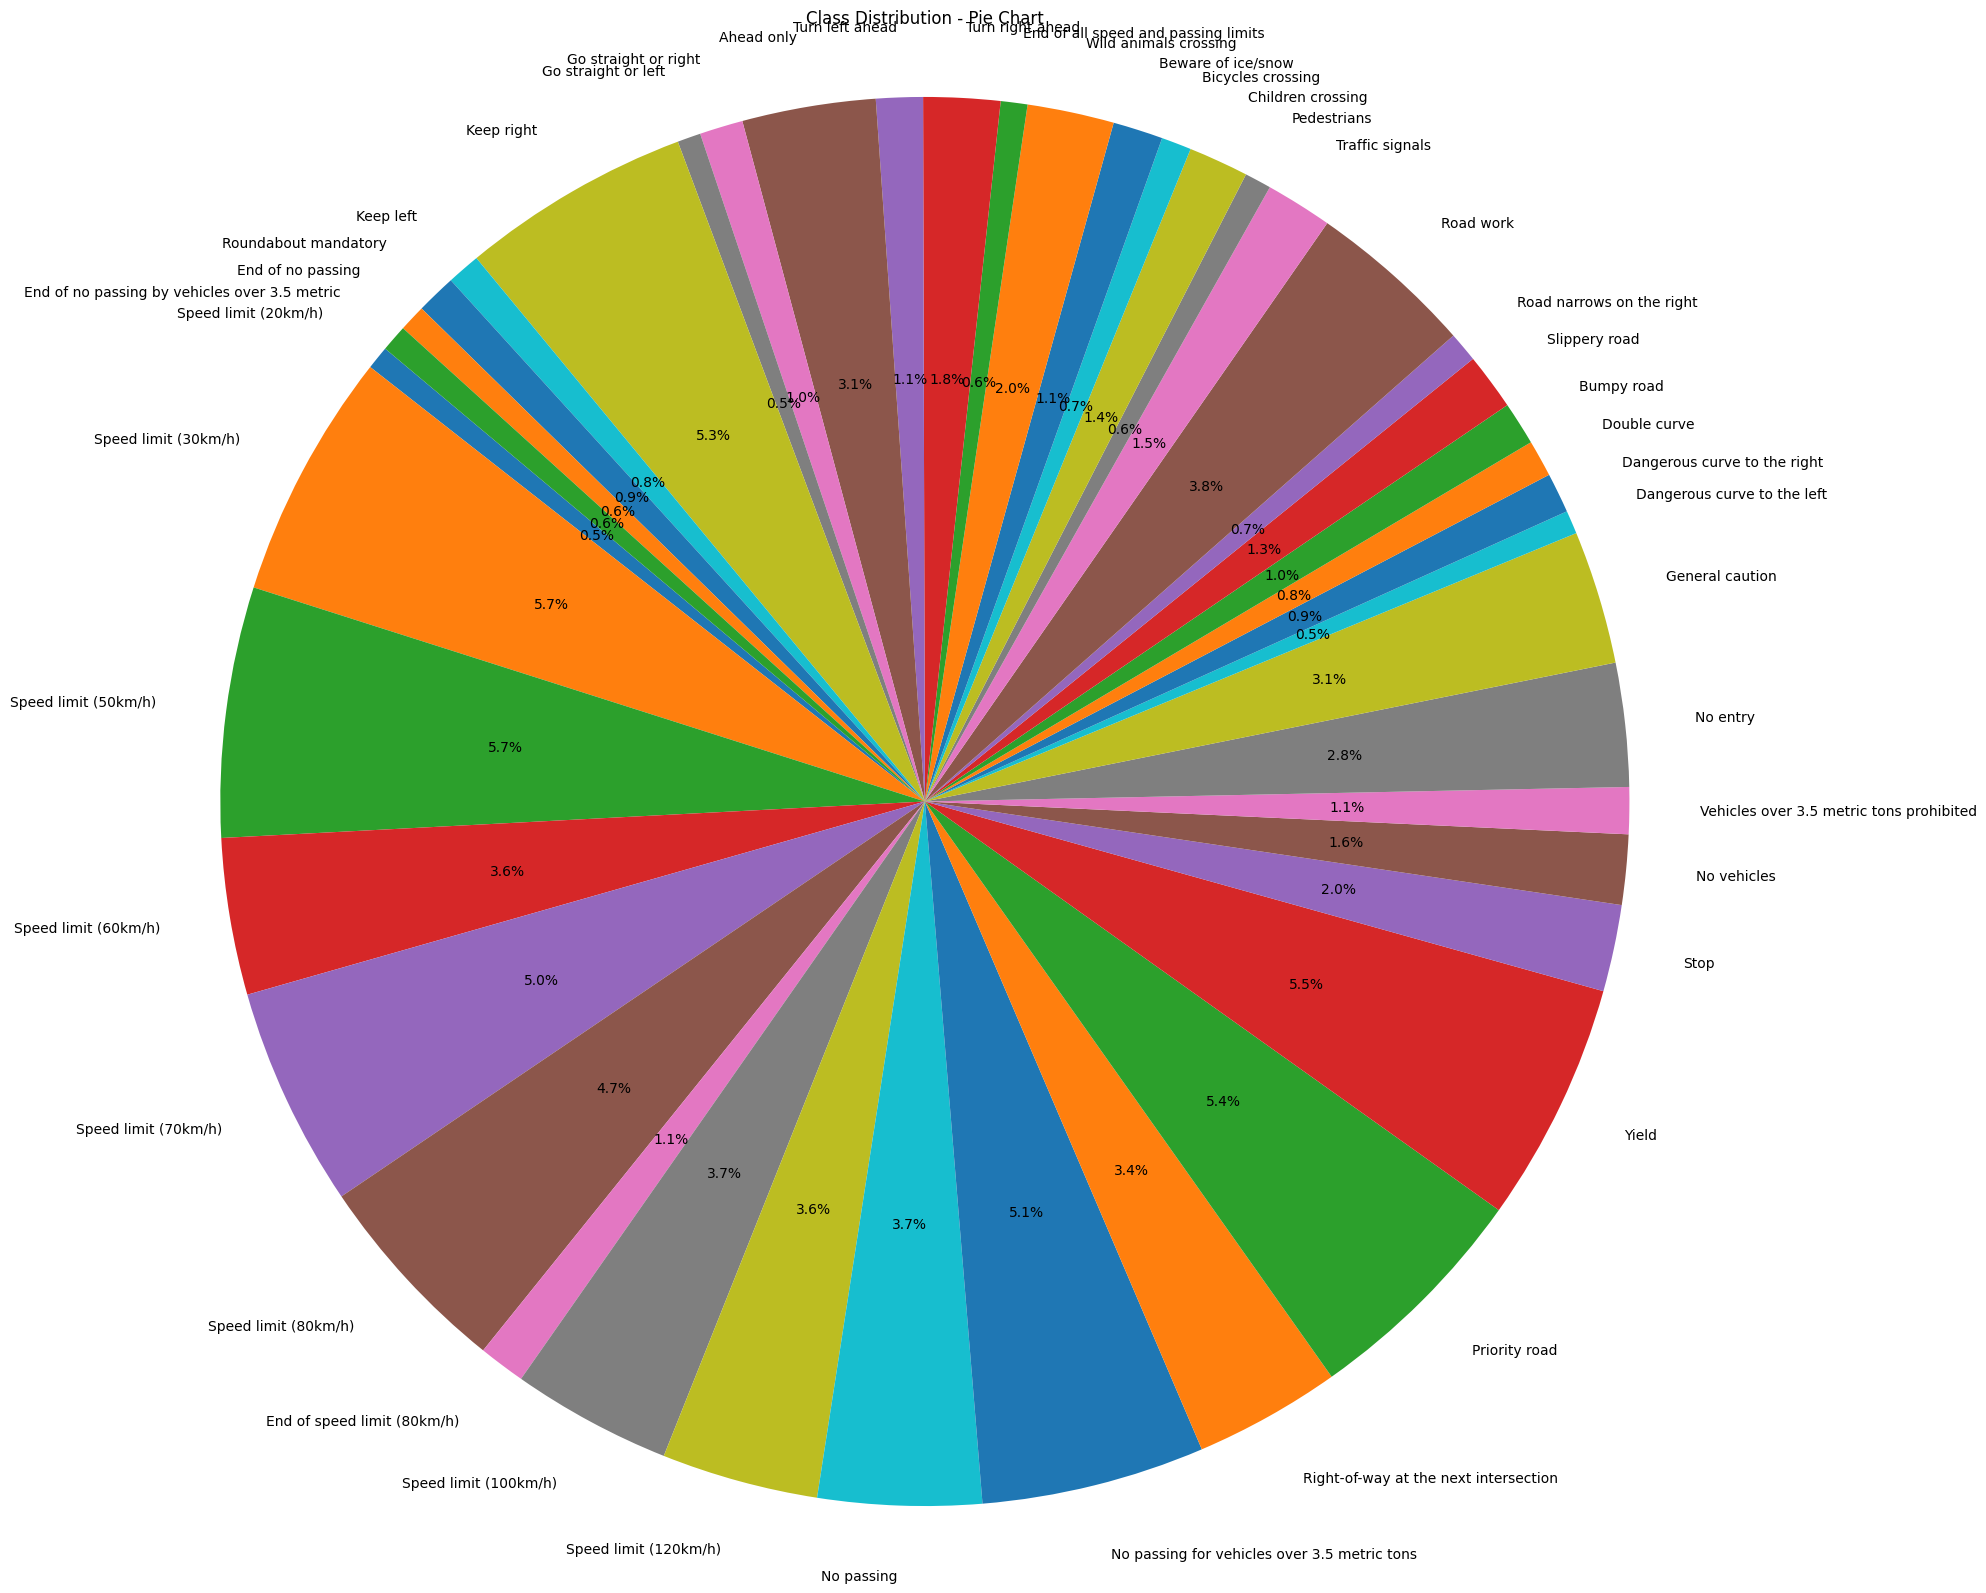

In [66]:
from torchvision.transforms import RandomHorizontalFlip, RandomRotation
img_dir = "/kaggle/input/gtsrb-german-traffic-sign/"
train_file = "/kaggle/input/gtsrb-german-traffic-sign/Train.csv"

df = pd.read_csv(train_file)
class_counts = df['ClassId'].value_counts().sort_index()


class_names = [
    "Speed limit (20km/h)", "Speed limit (30km/h)", "Speed limit (50km/h)", "Speed limit (60km/h)",
    "Speed limit (70km/h)", "Speed limit (80km/h)", "End of speed limit (80km/h)", "Speed limit (100km/h)",
    "Speed limit (120km/h)", "No passing", "No passing for vehicles over 3.5 metric tons",
    "Right-of-way at the next intersection", "Priority road", "Yield", "Stop", "No vehicles",
    "Vehicles over 3.5 metric tons prohibited", "No entry", "General caution", "Dangerous curve to the left",
    "Dangerous curve to the right", "Double curve", "Bumpy road", "Slippery road", "Road narrows on the right",
    "Road work", "Traffic signals", "Pedestrians", "Children crossing", "Bicycles crossing",
    "Beware of ice/snow", "Wild animals crossing", "End of all speed and passing limits", "Turn right ahead",
    "Turn left ahead", "Ahead only", "Go straight or right", "Go straight or left", "Keep right", "Keep left",
    "Roundabout mandatory", "End of no passing", "End of no passing by vehicles over 3.5 metric",
]


class_labels = [class_names[i] for i in class_counts.index]

plt.figure(figsize=(20,20))
plt.pie(class_counts.values, labels=class_labels, autopct='%1.1f%%', startangle=140)
plt.title("Class Distribution - Pie Chart")
plt.axis('equal')  # Equal aspect ratio for a circle
plt.show()


train_transform = Compose([
    Resize((30, 30)),
    ConvertImageDtype(torch.float32),
    RandomHorizontalFlip(p=0.5),
    RandomRotation(degrees=10),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_data = GTSRB(
    img_dir=img_dir,
    annotations_file=train_file,
    transform=train_transform
)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

Feature batch shape: torch.Size([32, 3, 30, 30])
Labels batch shape: torch.Size([32])


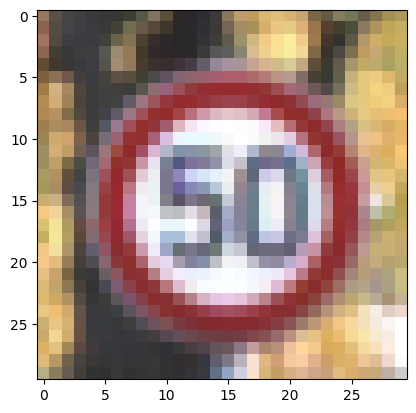

Label: 2


In [67]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
label = train_labels[0]
img = ToPILImage()(img).convert("RGB")
plt.imshow(img)
plt.show()
print(f"Label: {label}")

In [68]:
class conv_net(nn.Module):
    def __init__(self):
        super(conv_net, self).__init__()
        
        # First Convolutional Layer (Conv1)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)  # Output: 32x30x30
        self.bn1 = nn.BatchNorm2d(32)  # Batch Normalization
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling with 2x2 kernel
        
        # Second Convolutional Layer (Conv2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)  # Output: 64x30x30
        self.bn2 = nn.BatchNorm2d(64)  # Batch Normalization
        
        # Third Convolutional Layer (Conv3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)  # Output: 128x30x30
        self.bn3 = nn.BatchNorm2d(128)  # Batch Normalization
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, 512)  # Flattened size after pooling
        self.fc2 = nn.Linear(512, 43)  # Final output for 43 classes (as per GTSRB)

        # Dropout for regularization
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # First Convolution Layer -> ReLU -> Max Pooling -> BatchNorm
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        # Second Convolution Layer -> ReLU -> Max Pooling -> BatchNorm
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        # Third Convolution Layer -> ReLU -> Max Pooling -> BatchNorm
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten before fully connected layers
        x = x.view(-1, 128 * 3 * 3)  # Flatten the output for FC layers
        
        # Fully connected layer -> ReLU -> Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Dropout layer for regularization
        
        # Final Output Layer (class scores)
        x = self.fc2(x)
        return x


Epoch [1/15], Loss: 2.8574
Accuracy :0.1836
Epoch [2/15], Loss: 1.7947
Accuracy :0.4023
Epoch [3/15], Loss: 1.1497
Accuracy :0.6008
Epoch [4/15], Loss: 0.7280
Accuracy :0.7597
Epoch [5/15], Loss: 0.4291
Accuracy :0.8638
Epoch [6/15], Loss: 0.3048
Accuracy :0.9068
Epoch [7/15], Loss: 0.2237
Accuracy :0.9328
Epoch [8/15], Loss: 0.1803
Accuracy :0.9473
Epoch [9/15], Loss: 0.1604
Accuracy :0.9545
Epoch [10/15], Loss: 0.1396
Accuracy :0.9618
Epoch [11/15], Loss: 0.1369
Accuracy :0.9637
Epoch [12/15], Loss: 0.1271
Accuracy :0.9675
Epoch [13/15], Loss: 0.1106
Accuracy :0.9720
Epoch [14/15], Loss: 0.1119
Accuracy :0.9733
Epoch [15/15], Loss: 0.1062
Accuracy :0.9753


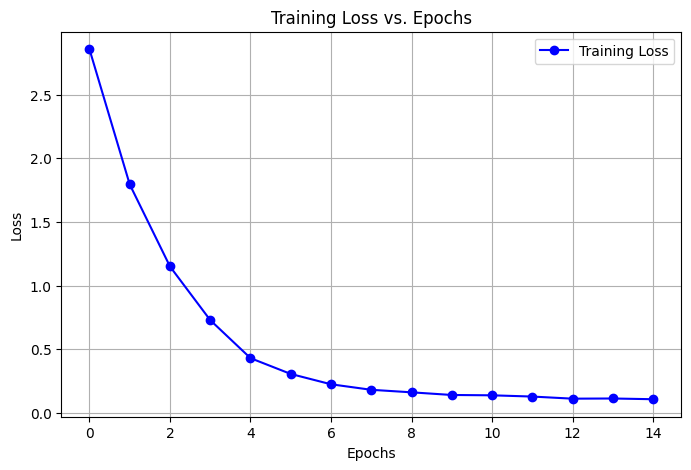

In [80]:
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score,confusion_matrix
model = conv_net()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
nb_epochs = 15
train_losses = []

for epoch in range(nb_epochs):
    running_loss = 0
    all_preds = []
    all_labels = []
    
    
    model.train()
    for i, (images, labels) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)  # Send data to the same device as model

        optimizer.zero_grad()  # Use optimizer here, not optim
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(outputs, 1)
        all_preds.extend(preds.cpu().numpy())  
        all_labels.extend(labels.cpu().numpy())  

    accuracy= accuracy_score(all_labels, all_preds)
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{nb_epochs}], Loss: {running_loss/len(train_dataloader):.4f}")
    print(f"Accuracy :{accuracy:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss", color='blue', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs. Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [81]:
test_img_dir = "/kaggle/input/gtsrb-german-traffic-sign/"
test_file = "/kaggle/input/gtsrb-german-traffic-sign/Test.csv"
# Dataset
test_data = GTSRB(
    img_dir=test_img_dir,
    annotations_file=test_file,
    transform=Compose([
        Resize((30, 30)),
        ConvertImageDtype(torch.float32),
    ])
)

# DataLoader
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [82]:
import matplotlib.pyplot as plt

model.eval()  # Set model to evaluation mode

all_preds = []
all_labels = []
test_loss = 0.0
test_losses = []  # To store the loss values for each batch

with torch.no_grad():  # No gradients needed during evaluation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Accumulate the loss for average calculation
        test_loss += loss.item()
        test_losses.append(loss.item())  # Append loss of current batch

        # Get predictions
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute overall metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
cm = confusion_matrix(all_labels, all_preds)

# Print results
print(f"Test Loss: {test_loss / len(test_loader):.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
print(f"Confusion Matrix:\n{cm}")


Test Loss: 0.4391
Test Accuracy: 0.9377
Precision: 0.9055, Recall: 0.9147, F1 Score: 0.9071
Confusion Matrix:
[[ 45   1   0 ...   0   0   0]
 [  0 692  16 ...   0   0   0]
 [  0   4 728 ...   0   0   0]
 ...
 [  0   0   3 ...  83   0   0]
 [  0   0   0 ...   0  42   3]
 [  0   0   0 ...   0  22  64]]


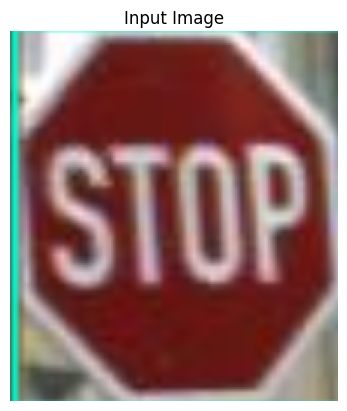

Predicted class index: 14
Predicted class name: Stop


In [83]:
from PIL import Image
import torch
from torchvision import transforms

# Path to your input image (any size)
image_path = "/kaggle/input/image3/Screenshot 2025-04-23 184952.png" 

# Transformation (must match training transforms)
transform = transforms.Compose([
    transforms.Resize((30, 30)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32)
])

# Load and transform the image
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

# Show image
plt.imshow(image)
plt.axis("off")
plt.title("Input Image")
plt.show()

# Prediction
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    predicted_index = torch.argmax(output, 1).item()
    predicted_class = class_names[predicted_index]

print(f"Predicted class index: {predicted_index}")
print(f"Predicted class name: {predicted_class}")



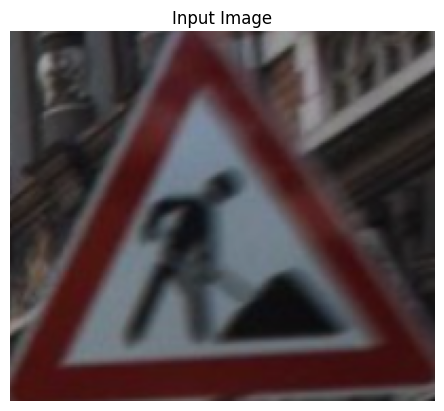

Predicted class index: 25
Predicted class name: Road work


In [84]:
from PIL import Image
import torch
from torchvision import transforms

# Path to your input image (any size)
image_path = "/kaggle/input/image2/Screenshot 2025-04-23 185001.png" 

# Transformation (must match training transforms)
transform = transforms.Compose([
    transforms.Resize((30, 30)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32)
])

# Load and transform the image
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

# Show image
plt.imshow(image)
plt.axis("off")
plt.title("Input Image")
plt.show()

# Prediction
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    predicted_index = torch.argmax(output, 1).item()
    predicted_class = class_names[predicted_index]

print(f"Predicted class index: {predicted_index}")
print(f"Predicted class name: {predicted_class}")


